# Data Engineer Technical Assignment
### Author: Konrad Wronski
Description: 
Technical assignment description
You are a data engineer working for a retail company. The company’s database handles large
volumes of data. You are tasked with creating a datalake in ADLS for reporting purposes.
For simplicity, instead of tables, assume files are in a source folder “Sales_Data” in csv format and
instead of ADLS, target location is “cleansed” folder (Create it yourself).
Source folder contains monthly sales data files.
1. Design the process to read all the files from source folder using PySpark, combine them
as a single file, and write it to the cleansed folder.
2. Which file format would you choose to write in the cleansed folder and why?
3. Mention data partitioning strategy you would propose for this table and justify your choice
of partitioning method.
4. Additionally, outline the steps you would take to implement this partitioning strategy,
considering both the technical aspects and potential challenges.
Note: Process all the files in a single run. Ensure that there is no data duplication.
[Hint: Make use of Window function for deduplication]
### Expected results of assignment:
- A notebook or python script.
- A separate documentation file with a brief explanation of the approach, data exploration,
assumptions/considerations, and instructions on how to run the application (if any).
- Output dataset in cleansed folder in your preferred file format.
- Data quality checks (like input/output dataset validation)
### Metyis development guidelines
- We appreciate a combination of Software and Data Engineering good practices.
- Proper logging and exception handling
### Evaluation criteria for results of technical assignment
We use following criteria to evaluate results:
- Well-structured code: we expect maintainability, readability.
- Scalability: Should be able to handle high volumes of data.
- Documentation

## 1. Data Ingestion 

### 1.1 Importing packages

In [184]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import os 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col,isnan, when, count, to_timestamp, to_date, date_format, row_number, col, year, month, sum, sum, avg, dayofweek
from pyspark.sql.window import Window


### 1.2 Initializing Session

 - Creating a PySpark session. 
 - Creating variables to change source path of the data and endpoint (target folder).

In [144]:
spark = SparkSession.builder.appName("SalesETL").getOrCreate()

In [145]:
source = "/Users/konradwronski/Desktop/Projects/Grind/DataScienceJungle/MetyisTask/Sales_Data"
endpoint = "/Users/konradwronski/Desktop/Projects/Grind/DataScienceJungle/MetyisTask/Cleansed"

### 1.2.1 Checking the file 

Initial data exploration to check the columns and values in the columns. 

In [146]:
df = spark.read.options(header = True, inferSchema = True).csv("/Users/konradwronski/Desktop/Projects/Grind/DataScienceJungle/MetyisTask/Sales_Data/Sales_April_2019.csv")

In [147]:
df.show()

+--------+--------------------+----------------+----------+--------------+--------------------+
|Order ID|             Product|Quantity Ordered|Price Each|    Order Date|    Purchase Address|
+--------+--------------------+----------------+----------+--------------+--------------------+
|  176558|USB-C Charging Cable|               2|     11.95|04/19/19 08:46|917 1st St, Dalla...|
|    NULL|                NULL|            NULL|      NULL|          NULL|                NULL|
|  176559|Bose SoundSport H...|               1|     99.99|04/07/19 22:30|682 Chestnut St, ...|
|  176560|        Google Phone|               1|     600.0|04/12/19 14:38|669 Spruce St, Lo...|
|  176560|    Wired Headphones|               1|     11.99|04/12/19 14:38|669 Spruce St, Lo...|
|  176561|    Wired Headphones|               1|     11.99|04/30/19 09:27|333 8th St, Los A...|
|  176562|USB-C Charging Cable|               1|     11.95|04/29/19 13:03|381 Wilson St, Sa...|
|  176563|Bose SoundSport H...|         

In [148]:
df.printSchema()

root
 |-- Order ID: integer (nullable = true)
 |-- Product: string (nullable = true)
 |-- Quantity Ordered: integer (nullable = true)
 |-- Price Each: double (nullable = true)
 |-- Order Date: string (nullable = true)
 |-- Purchase Address: string (nullable = true)



### 1.3 Loading the data 

Creating an empty Data Frame to store merged files.

In [149]:
salesSchema = StructType([StructField('Order ID',
                                  IntegerType(), True),
                    StructField('Product',
                                StringType(), True),
                    StructField('Quantity Ordered',
                                IntegerType(), True),
                    StructField('Price Each',
                                DoubleType(), True),
                    StructField('Order Date',
                                StringType(), True),
                    StructField('Purchase Address',
                                StringType(), True)
                    ])
sales = spark.createDataFrame(data = [], schema = salesSchema)

In [150]:
def load(file, base):
    '''Function loading and merging all of the datasets/tables'''
    dfFile = spark.read.options(header = True).schema(salesSchema).csv(file)
    base = base.unionByName(dfFile)
    return base

Looping through all of the files in the Sales Data folder to merge them into one. Data Quality check to ensure new files are being appended.

In [151]:
directory = os.fsencode(source)

for file in os.listdir(directory): 
    filename = os.path.join(source, os.fsdecode(file))
    sales = load(filename, sales)
    print(f"File {file} has been loaded and appended to the main file. Current Length of the file {sales.count()}")

File b'Sales_December_2019.csv' has been loaded and appended to the main file. Current Length of the file 25117
File b'Sales_April_2019.csv' has been loaded and appended to the main file. Current Length of the file 43500
File b'Sales_February_2019.csv' has been loaded and appended to the main file. Current Length of the file 55536
File b'Sales_March_2019.csv' has been loaded and appended to the main file. Current Length of the file 70762
File b'Sales_August_2019.csv' has been loaded and appended to the main file. Current Length of the file 82773
File b'Sales_May_2019.csv' has been loaded and appended to the main file. Current Length of the file 99408
File b'Sales_November_2019.csv' has been loaded and appended to the main file. Current Length of the file 117069
File b'Sales_October_2019.csv' has been loaded and appended to the main file. Current Length of the file 137448
File b'Sales_January_2019.csv' has been loaded and appended to the main file. Current Length of the file 147171
File

## 2. Data Transformation & Cleaning

Changing column names formatting for easier handling

In [153]:
newColumns = []
problematic_chars = ',;{}()='
for column in sales.columns:
    column = column.lower()
    column = column.replace(' ', '_')
    for c in problematic_chars:
        column = column.replace(c, '')
    newColumns.append(column)
sales = sales.toDF(*newColumns)

In [185]:
sales.columns

['order_id',
 'product',
 'quantity_ordered',
 'price_each',
 'order_date',
 'purchase_address']

### 2.1 Handling Missing Values

Checking the number of missing values for each column.

In [154]:
sales.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sales.columns]).show()

+--------+-------+----------------+----------+----------+----------------+
|order_id|product|quantity_ordered|price_each|order_date|purchase_address|
+--------+-------+----------------+----------+----------+----------------+
|     900|    545|             900|       900|       545|             545|
+--------+-------+----------------+----------+----------+----------------+



Investigating rows with missing values.

In [155]:
missing_data_rows = sales.filter(
    (col("order_id").isNull()) | (col("product").isNull()) | 
    (col("quantity_ordered").isNull()) | (col("price_each").isNull()) |
    (col("order_date").isNull()) | (col("purchase_address").isNull()) |
    (isnan("order_id")) | (isnan("product")) | 
    (isnan("quantity_ordered")) | (isnan("price_each")) |
    (isnan("order_date")) | (isnan("purchase_address"))
)
missing_data_rows.show(truncate=False)

+--------+-------+----------------+----------+----------+----------------+
|order_id|product|quantity_ordered|price_each|order_date|purchase_address|
+--------+-------+----------------+----------+----------+----------------+
|NULL    |Product|NULL            |NULL      |Order Date|Purchase Address|
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |Product|NULL            |NULL      |Order Date|Purchase Address|
|NULL    |Product|NULL            |NULL      |Order Date|Purchase Address|
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |NULL   |NULL            |NULL      |NULL      |NULL            |
|NULL    |Product|NULL   

Dropping rows with missing values due to specificity of the rows that contain missing values. 

In [156]:
sales = sales.dropna(how="any")

Confirm the are no more missing values. 

In [157]:
sales.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sales.columns]).show()

+--------+-------+----------------+----------+----------+----------------+
|order_id|product|quantity_ordered|price_each|order_date|purchase_address|
+--------+-------+----------------+----------+----------+----------------+
|       0|      0|               0|         0|         0|               0|
+--------+-------+----------------+----------+----------+----------------+



### 2.2 Checking for duplicates 

Removing duplicated rows using window function.

In [158]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

window_spec = Window.partitionBy("order_id", "product", "quantity_ordered", "price_each", "purchase_address") \
                    .orderBy(col("order_date").desc())
salesDeduplicated= sales.withColumn("row_num", row_number().over(window_spec))
salesDeduplicated = salesDeduplicated.filter(col("row_num") == 1).drop("row_num")

print(f'In a deduplication process {sales.count() - salesDeduplicated.count()} rows were removed')

In a deduplication process 264 rows were removed


### 2.3 Transforming order_date column 

Changing column data type to timestamp then spliting into two columns: Timestamp and Date

In [159]:
salesDeduplicated = salesDeduplicated.withColumn("order_date", to_timestamp("order_date", "MM/dd/yy HH:mm"))
salesDeduplicated = salesDeduplicated.withColumn("order_timestamp", date_format("order_date", "HH:mm"))
salesDeduplicated = salesDeduplicated.withColumn("order_date", to_date("order_date"))

In [160]:
salesDeduplicated.show()

+--------+--------------------+----------------+----------+----------+--------------------+--------------+
|order_id|             product|quantity_ordered|price_each|order_date|    purchase_address|order_imestamp|
+--------+--------------------+----------------+----------+----------+--------------------+--------------+
|  141250|     Vareebadd Phone|               1|     400.0|2019-01-10|471 Center St, Lo...|         11:20|
|  141254|AAA Batteries (4-...|               1|      2.99|2019-01-08|238 Sunset St, Se...|         11:51|
|  141265|Apple Airpods Hea...|               1|     150.0|2019-01-01|853 Ridge St, Bos...|         16:52|
|  141270|    Wired Headphones|               1|     11.99|2019-01-27|469 Hill St, San ...|         23:10|
|  141275|    Wired Headphones|               1|     11.99|2019-01-07|610 Walnut St, Au...|         16:06|
|  141321|Bose SoundSport H...|               1|     99.99|2019-01-10|207 8th St, Los A...|         09:07|
|  141334|USB-C Charging Cable|      

## 3. Loading Data into new folder

- Parquet file has been chosen as a destination format as it is: columnar and supports compression 
- Partitioning strategy for this file is per month and year. The reason for this choice is that sales data are often used to compare certain time frames.

In [161]:
salesDeduplicated = salesDeduplicated.withColumn("year", year(col("order_date")))
salesDeduplicated = salesDeduplicated.withColumn("month", month(col("order_date")))

In [162]:
salesDeduplicated.write.mode("overwrite").partitionBy("year", "month").parquet(endpoint)

25/02/18 12:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
25/02/18 12:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
25/02/18 12:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
25/02/18 12:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
25/02/18 12:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 84.47% for 8 writers
25/02/18 12:59:13 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014 bytes) of heap memory
Scaling row group sizes to 96.54% for 7 writers
25/02/18 12:59:14 WARN MemoryManager: Total allocation exceeds 95.00% (906,992,014

In [163]:
input_count = salesDeduplicated.count()
output_count = spark.read.parquet(endpoint).count()
assert input_count == output_count, "Data loss"

## 4. Data Visualization

### In this part lets investigate what insights can we obtain from this retail data.

### 4.1 Top Selling Products

Lets start with checking which products sell the best. Below chart depicts top 10 selling products.

/var/folders/1m/mckmrfpx3yn1g1wj1m8cxm000000gn/T/ipykernel_17704/2293428285.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


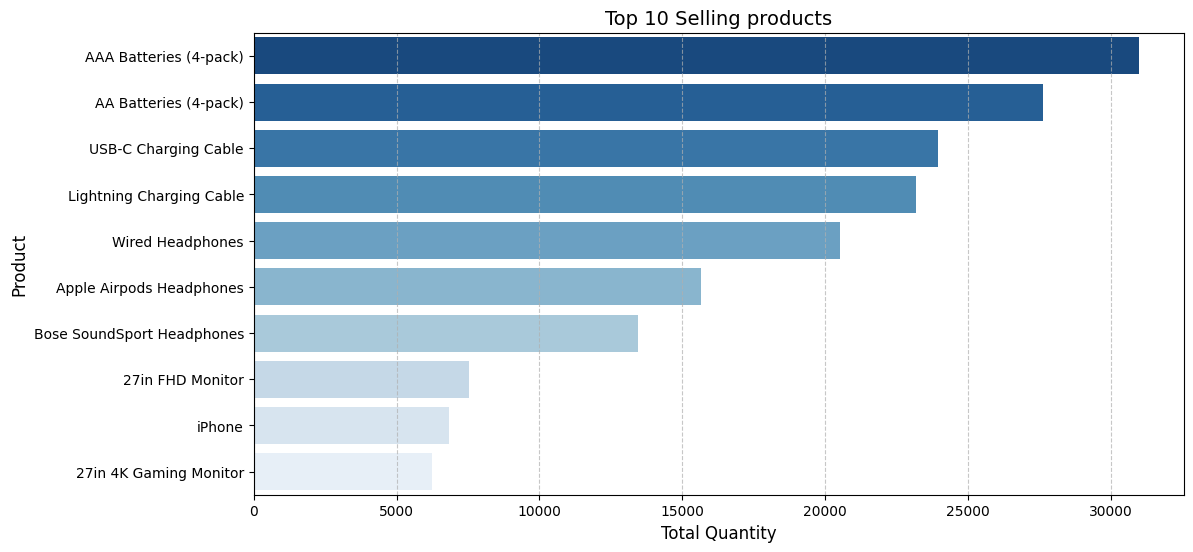

In [164]:
# Aggregating top products
top_products = (
    salesDeduplicated.groupBy("product")
    .agg(sum("quantity_ordered").alias("Total Quantity"))
    .orderBy(col("Total Quantity").desc())
    .limit(10)
)

# Converting to pandas
top_products_pd = top_products.toPandas()

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_products_pd["Total Quantity"],
    y=top_products_pd["product"],
    palette="Blues_r"
)
plt.xlabel("Total Quantity", fontsize=12)
plt.ylabel("Product", fontsize=12)
plt.title("Top 10 Selling products", fontsize=14)
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.show()

The best selling items in terms of quantity are batteries with over 50000 sold units. Charging cables are also sellling very well with both USB-C and Lightning selling over 22500 units. 

### 4.2 Total Sales per month

One of the most important metrics for every retail company is an analysis of their sales for each month to spot seasonal trends.

In [168]:
# Creating new column with total value of the order
salesDeduplicated = salesDeduplicated.withColumn("total_value", salesDeduplicated.price_each * salesDeduplicated.quantity_ordered)

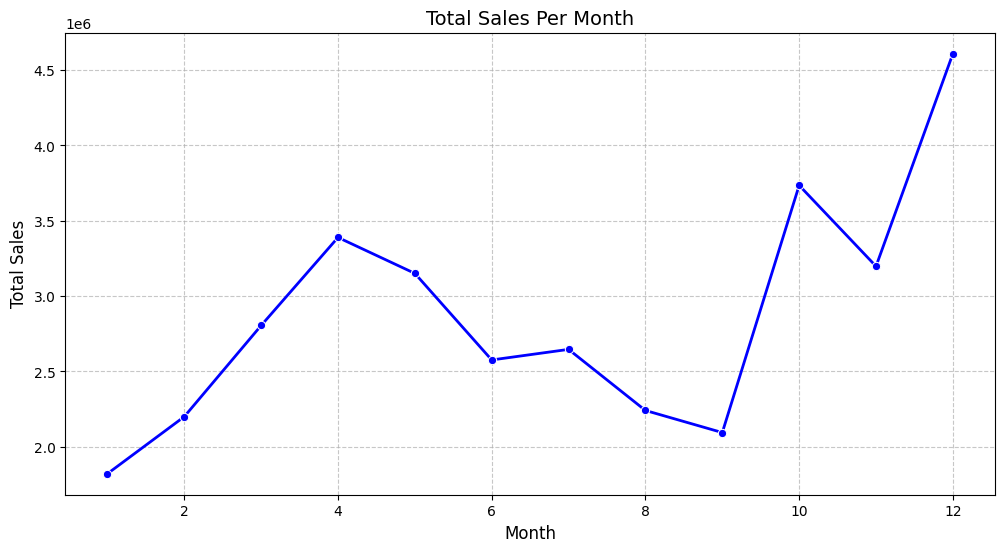

In [171]:
monthlySales = (
    salesDeduplicated.withColumn("month", month(col("order_date")))
    .groupBy("month")
    .agg(sum("total_value").alias("total_sales"))
    .orderBy("month")
)

monthlysalespd = monthlySales.toPandas()

plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    x=monthlysalespd["month"]
    y=monthlysalespd["total_sales"],
    marker="o",  
    color="b", 
    linewidth=2
)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.title("Total Sales Per Month", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### 4.3 Day of the week 

Analysing which day of the week the sales are the biggest can provide very important insights that can support marketing decisioning or resource allocation in company. 

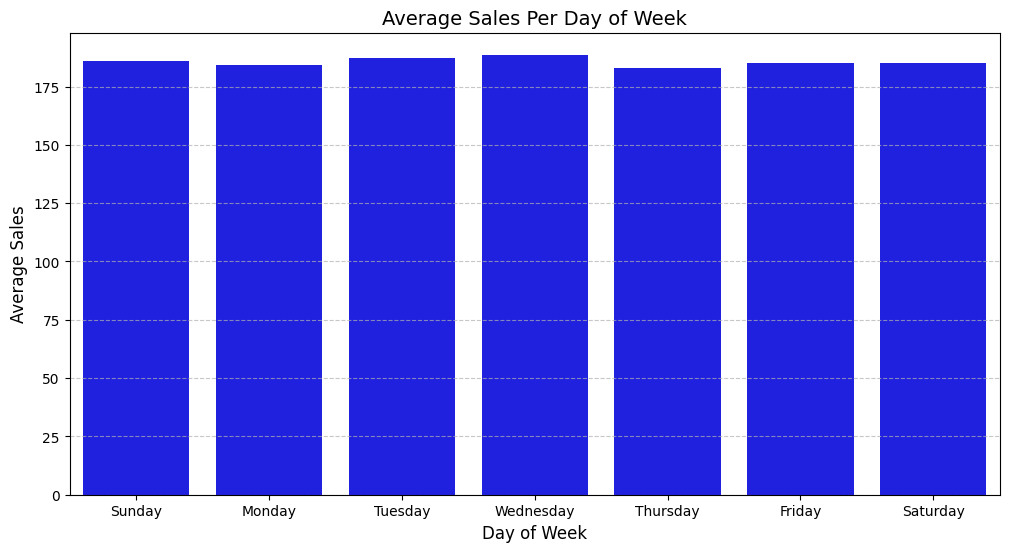

In [176]:
# Extracting the day of the week 
salesDayOfWeek = salesDeduplicated.withColumn("day_of_week", dayofweek(col("order_date")))

# Average sales per day of the week
avgSalesPerDay = (
    salesDayOfWeek.groupBy("day_of_week")
    .agg(avg("total_value").alias("average_sales"))
    .orderBy("day_of_week")
)

# Converting to pandas
avgSalesPerDaypd = avgSalesPerDay.toPandas()
day_mapping = {
    1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
    5: 'Thursday', 6: 'Friday', 7: 'Saturday'
}
avgSalesPerDaypd["day_name"] = avgSalesPerDaypd["day_of_week"].map(day_mapping)

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=avgSalesPerDaypd["day_name"],
    y=avgSalesPerDaypd["average_sales"],
    color="blue"
)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Average Sales", fontsize=12)
plt.title("Average Sales Per Day of Week", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
